In [1]:
# Import the required libraries
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# Emotion mapping from RAVDESS filenames
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_emotion_from_filename(filename):
    parts = filename.split('-')
    emotion_code = parts[2]
    return emotion_map.get(emotion_code)

def extract_mfcc_features(file_path, n_mfcc=40, max_len=200):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        if mfccs.shape[1] < max_len:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [3]:
# Load and process dataset
data_path = 'data/'
X = []
y = []

for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            emotion = extract_emotion_from_filename(file)
            if emotion:
                file_path = os.path.join(root, file)
                mfccs = extract_mfcc_features(file_path)
                if mfccs is not None:
                    X.append(mfccs)
                    y.append(emotion)

X = np.array(X)
y = np.array(y)
print(f"Extracted {len(X)} samples with shape: {X.shape}")

Extracted 60 samples with shape: (60, 40, 200)


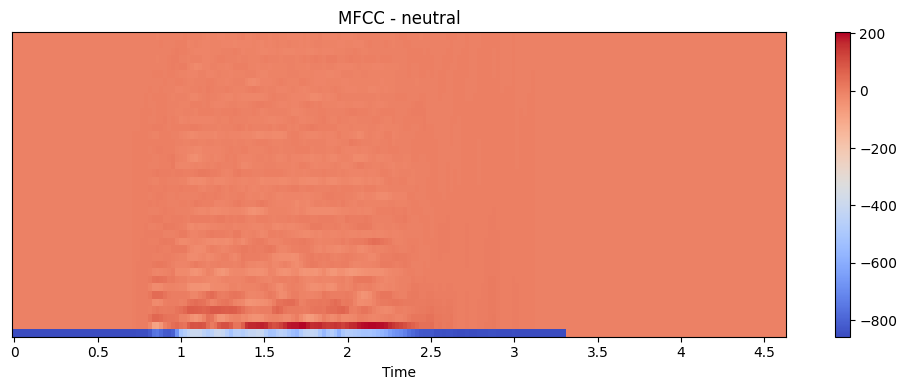

In [4]:
# Visualize MFCC model
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0], x_axis='time')
plt.colorbar()
plt.title(f'MFCC - {y[0]}')
plt.tight_layout()
plt.show()

In [5]:
# Encode Labels and train/test
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

In [6]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


d:\Project\Machine Learning\codealpha_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 48, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,145,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,165,704 (12.08 MB)

 Trainable params: 3,165,704 (12.08 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.0486 - loss: 26.7122 - val_accuracy: 0.2500 - val_loss: 32.9235
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1389 - loss: 52.9546 - val_accuracy: 0.1667 - val_loss: 13.5419
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3333 - loss: 21.1008 - val_accuracy: 0.2500 - val_loss: 7.9806
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2674 - loss: 12.4912 - val_accuracy: 0.1667 - val_loss: 4.5116
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3264 - loss: 4.9376 - val_accuracy: 0.1667 - val_loss: 2.7703
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4826 - loss: 1.4926 - val_accuracy: 0.1667 - val_loss: 1.7728
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5139 - loss: 1.3526 - val_accuracy: 0.2500 - val_loss: 1.6501
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4514 - loss: 1.3641 - val_accuracy: 0.1667 - val

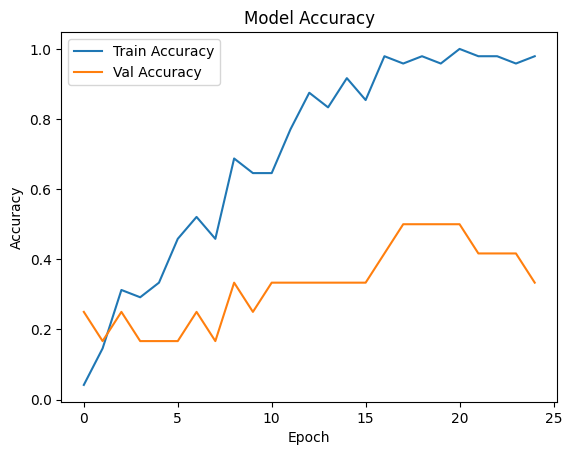

In [8]:
# Visualize training Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.2f}")

✅ Test Accuracy: 0.33


In [10]:
# Sample Predictions
import random

y_test_labels = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
emotions = label_encoder.classes_

for i in range(5):
    idx = random.randint(0, len(X_test) - 1)
    print(f"Sample #{i+1}")
    print("Predicted Emotion:", emotions[y_pred_labels[idx]])
    print("Actual Emotion:   ", emotions[y_test_labels[idx]])
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Sample #1
Predicted Emotion: happy
Actual Emotion:    fearful
------------------------------
Sample #2
Predicted Emotion: neutral
Actual Emotion:    neutral
------------------------------
Sample #3
Predicted Emotion: sad
Actual Emotion:    disgust
------------------------------
Sample #4
Predicted Emotion: calm
Actual Emotion:    happy
------------------------------
Sample #5
Predicted Emotion: happy
Actual Emotion:    fearful
------------------------------



📊 Classification Report:

              precision    recall  f1-score   support

       angry       0.33      1.00      0.50         1
        calm       0.33      1.00      0.50         1
     disgust       0.00      0.00      0.00         2
     fearful       0.00      0.00      0.00         2
       happy       0.25      0.50      0.33         2
     neutral       1.00      1.00      1.00         1
         sad       0.00      0.00      0.00         1
   surprised       0.00      0.00      0.00         2

    accuracy                           0.33        12
   macro avg       0.24      0.44      0.29        12
weighted avg       0.18      0.33      0.22        12



d:\Project\Machine Learning\codealpha_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Project\Machine Learning\codealpha_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Project\Machine Learning\codealpha_env\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

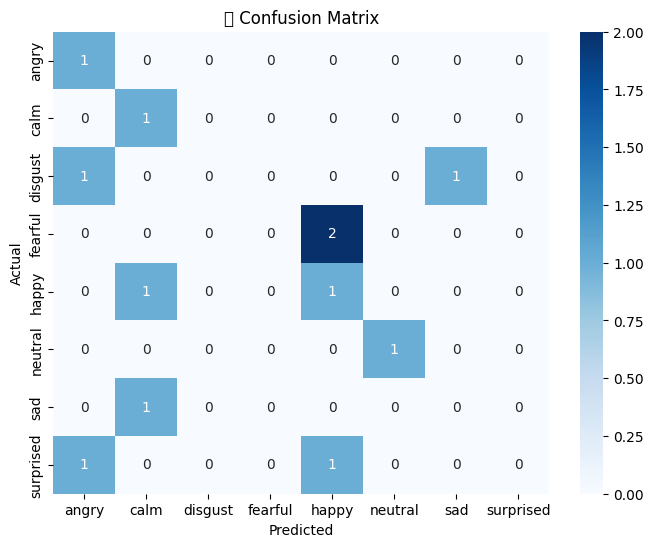

In [11]:
# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n📊 Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels, target_names=emotions))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix")
plt.show()

In [12]:
# Predict on New Audio
def predict_emotion(file_path):
    mfcc = extract_mfcc_features(file_path)
    if mfcc is None:
        print("❌ Could not extract MFCC.")
        return
    mfcc = mfcc.reshape(1, 40, 200, 1)
    prediction = model.predict(mfcc)
    predicted_label = np.argmax(prediction)
    emotion = emotions[predicted_label]
    print(f"🎤 Predicted Emotion: {emotion}")

In [13]:
# Test the model with a file
predict_emotion("test_audio.wav")  # Replace with your test file name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🎤 Predicted Emotion: angry


In [14]:
# save model
model.save("emotion_cnn_model.h5")